# Gaussian Process Regressors

In [328]:
import math
import random
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared,
    ConstantKernel,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_squared_error,
)
from sklearn.base import clone
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from datetime import datetime

## Data Loading and Feature Engineering

<font size="3">Here we import the dataset and apply the same feature engineering as described in the notebook ```mlfcs/experiments/miro
/2.0-mz-preprocessing.ipynb```.<font>

In [331]:
random.seed(0)
np.random.seed(0)

LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

full_data = (
    (
        pl.read_csv("btc/data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .to_pandas()
    .set_index("datetime")
)

full_data["vol"] = np.log(full_data["vol"])
full_data["volume"] = np.log(full_data["volume"])
full_data.rename(columns={"vol": "log_vol"}, inplace=True)
full_data.rename(columns={"volume": "log_volume"}, inplace=True)


full_data = full_data.copy().drop(
    columns=[
        col
        for col in full_data.columns
        if col.startswith("ret")
        or col.startswith("ask_depth")
        or col.startswith("depth_diff")
    ]
)

In [332]:
full_data = full_data.copy().drop(
    columns=[col for col in full_data.columns if col.startswith("volume_diff")]
)
print(f"Number of features: {full_data.shape[1] - 1}")

Number of features: 841


<font size="3">We now add log-volatility features to the dataset.<font>

In [334]:
log_vol_index = full_data.columns.get_loc("log_vol")

full_data.insert(
    loc=log_vol_index + 1,
    column="log_vol_ma24",
    value=full_data["log_vol"].shift(1).rolling(window=24).mean(),
)

full_data.insert(
    loc=log_vol_index + 1,
    column="log_vol_ma6",
    value=full_data["log_vol"].shift(1).rolling(window=6).mean(),
)

full_data.insert(
    loc=log_vol_index + 1, column="log_vol_t-1", value=full_data["log_vol"].shift(1)
)


full_data = full_data.dropna()

In [335]:
full_data

,log_vol,log_vol_t-1,log_vol_ma6,log_vol_ma24,spread_t-1,bid_depth_t-1,ask_volume_t-1,bid_volume_t-1,weighted_spread_t-1,ask_slope_t-1,...,ask_slope_t-119,bid_slope_t-119,spread_t-120,bid_depth_t-120,ask_volume_t-120,bid_volume_t-120,weighted_spread_t-120,ask_slope_t-120,bid_slope_t-120,log_volume
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-05 23:00:00,-9.395672,-9.600540,-8.916600,-8.673882,3.02,2847.0,2247.548011,12582.701382,1047.332839,7673.23,...,7693.29,7010.0,0.01,2864.0,2267.903872,12596.326211,1086.231195,7676.59,7010.0,4.595965
2018-06-06 00:00:00,-9.348389,-9.395672,-9.063109,-8.696391,4.98,2864.0,2272.821229,12597.542881,1084.836117,7676.27,...,7668.29,7010.0,5.99,2865.0,2306.013221,12633.015888,1127.487081,7668.29,7010.0,4.041086
2018-06-06 01:00:00,-9.185994,-9.348389,-9.262724,-8.708069,5.97,2864.0,2303.913832,12628.213499,1122.776876,7668.97,...,7660.89,7010.0,5.37,2867.0,2270.945527,12642.489309,1120.228052,7660.89,7010.0,4.735400
2018-06-06 02:00:00,-9.482964,-9.185994,-9.203051,-8.702541,8.02,2864.0,2279.082323,12635.583395,1125.756027,7659.00,...,7694.92,7010.0,8.77,2856.0,2327.383238,12601.486379,1085.621784,7685.31,7010.0,5.327580
2018-06-06 03:00:00,-9.069514,-9.482964,-9.254608,-8.781163,7.48,2858.0,2329.881418,12602.886330,1082.952454,7685.31,...,7674.41,7010.0,6.59,2859.0,2312.037409,12565.770654,1038.665731,7674.41,7010.0,4.499403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 17:00:00,-10.582381,-10.582816,-10.742739,-10.363791,2.51,2837.0,2634.212985,11905.433650,990.015651,6618.00,...,6629.00,6060.0,0.08,2841.0,2627.367204,11909.731066,1051.144353,6629.00,6060.0,4.657951
2018-09-30 18:00:00,-11.200888,-10.582381,-10.727725,-10.396945,0.08,2841.0,2627.386158,11908.671066,1050.033244,6629.00,...,6631.00,6060.0,3.13,2840.0,2614.198169,11899.085884,969.486671,6631.00,6060.0,3.293007
2018-09-30 19:00:00,-10.642258,-11.200888,-10.879202,-10.436798,3.11,2844.0,2614.121173,11901.490484,971.968267,6631.00,...,6628.00,6060.0,3.89,2841.0,2597.208539,11936.342886,1066.514037,6628.00,6060.0,3.895184


<font size="3">We now generate the final OB features.<font>

In [336]:
ct_features = ["spread", "bid_depth", "ask_volume"]

for col in ct_features:
    full_data[f"mean_{col}"] = full_data.loc[
        :, full_data.columns.str.startswith(col)
    ].mean(axis=1)

disp_features = ["bid_depth", "ask_volume", "ask_slope"]

for col in disp_features:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))
    full_data[f"iq_range_{col}"] = np.log(
        0.0001
        + (
            full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1)
            - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1)
        )
        / full_data.loc[:, columns_to_use[:]].median(axis=1)
    )

In [337]:
final_features = (
    ["log_vol_t-1"]
    + ["log_vol_ma6"]
    + ["log_vol_ma24"]
    + ["log_volume"]
    + [f"mean_{col}" for col in ct_features]
    + [f"iq_range_{col}" for col in disp_features]
)

In [338]:
full_data = full_data.loc[:, ["log_vol"] + final_features]
full_data

,log_vol,log_vol_t-1,log_vol_ma6,log_vol_ma24,log_volume,mean_spread,mean_bid_depth,mean_ask_volume,iq_range_bid_depth,iq_range_ask_volume,iq_range_ask_slope
datetime,,,,,,,,,,,
2018-06-05 23:00:00,-9.395672,-9.600540,-8.916600,-8.673882,4.595965,4.339000,2854.916667,2242.934275,-6.118582,-5.075595,-7.587819
2018-06-06 00:00:00,-9.348389,-9.395672,-9.063109,-8.696391,4.041086,4.669583,2860.983333,2280.225762,-7.132079,-4.212557,-6.813087
2018-06-06 01:00:00,-9.185994,-9.348389,-9.262724,-8.708069,4.735400,5.221000,2862.116667,2276.860574,-6.769863,-4.158290,-6.831365
2018-06-06 02:00:00,-9.482964,-9.185994,-9.203051,-8.702541,5.327580,4.654083,2860.375000,2315.646031,-5.972286,-4.296181,-7.102543
2018-06-06 03:00:00,-9.069514,-9.482964,-9.254608,-8.781163,4.499403,4.913000,2858.625000,2342.686001,-7.131467,-5.036392,-6.521619
...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 17:00:00,-10.582381,-10.582816,-10.742739,-10.363791,4.657951,2.713750,2839.141667,2626.154969,-7.125323,-5.725597,-7.500707
2018-09-30 18:00:00,-11.200888,-10.582381,-10.727725,-10.396945,3.293007,3.495083,2842.358333,2610.819406,-6.763462,-5.195273,-6.743640
2018-09-30 19:00:00,-10.642258,-11.200888,-10.879202,-10.436798,3.895184,2.176917,2844.933333,2596.672610,-7.127171,-5.988073,-7.501572


In [339]:
model_output = pd.read_csv("Model_output_template.csv")
model_output["datetime"] = pd.to_datetime(model_output["datetime"])

mask = full_data.index.isin(model_output["datetime"])

test_vols = full_data.loc[mask]
retrain_times = model_output.loc[
    model_output["retraining_flag"], "datetime"
].sort_values()
retrain_times = pd.to_datetime(retrain_times)

<font size="3">The following function splits the full dataset into the chosen training/testing datasets. It returns a list of ```(train_set, test_set)``` tuples. <font>

In [340]:
def get_train_test_pairs(
    full_data,
    retrain_times,
    lookback=pd.Timedelta(days=30),
    freq_lag=pd.Timedelta(hours=1),
    expanding=False,
):
    df = full_data.copy()
    df.index = pd.to_datetime(df.index)

    pairs = []
    for cur_test, next_test in zip(retrain_times, retrain_times.shift(-1)):
        if expanding:
            train_start = df.index.min()
        else:
            train_start = cur_test - lookback

        train_end = cur_test - freq_lag
        train = df.loc[train_start:train_end]

        if pd.isna(next_test):
            test = df.loc[cur_test:]
        else:
            test = df.loc[cur_test : next_test - pd.Timedelta(microseconds=1)]
        pairs.append((train, test))

    return pairs

In [341]:
rolling_train_test_pairs = get_train_test_pairs(full_data, retrain_times)
expanding_train_test_pairs = get_train_test_pairs(
    full_data, retrain_times, expanding=True
)

## The GP Models

<font size="3">The following backtester goes through a provided list of training/testing set tuples, fits a Gaussian process regressor with a chosen kernel to the training set, and performs a one-step ahead forecast over the corresponding testing set. The models are then retrained at the window boundaries, using the previously estimated kernel hyperparameters as the optimizer’s starting value.
<font>

<font size="3">It should be noted that in the cases where a periodic kernel is used, the backtester enforces a bound on the periodicity of the kernel based on the length of the training set. Concretely, it limits the estimated periodicity so that it cannot exceed half of the length of the provided training set, or fall below two hours.
<font>

In [343]:
def back_tester(
    train_test_pairs,
    kernel=None,
    model_output_temp=model_output,
    n_restarts_optimizer=20,
    periodic_kernel=False,
    naive=False,
):
    assert not (kernel is None and naive is False), (
        "Must supply a kernel when naive=False"
    )
    num_pairs = len(train_test_pairs)
    model_output_res = model_output_temp.copy()
    prev_kernel = kernel

    for i in range(num_pairs):
        cur_train_set = train_test_pairs[i][0]
        cur_test_set = train_test_pairs[i][1]

        cur_test_datetimes = cur_test_set.index

        if naive:
            model_output_res = model_output_res.rename(columns={"model_name": "Naive"})
            combined_log = pd.concat(
                [cur_train_set["log_vol"], cur_test_set["log_vol"]]
            ).sort_index()

            naive_log_preds = combined_log.shift(1).loc[cur_test_datetimes]
            vol_preds = np.exp(naive_log_preds.values)
            vol_preds_pd = pd.Series(vol_preds, index=cur_test_datetimes)
            mapped = model_output_res["datetime"].map(vol_preds_pd)
            model_output_res["Naive"] = model_output_res["Naive"].fillna(mapped)
            continue
        else:
            model_output_res = model_output_res.rename(columns={"model_name": "GP"})

        cur_y_train = cur_train_set["log_vol"].values
        cur_X_train = cur_train_set.iloc[:, 1:].values

        X_scaler = StandardScaler().fit(cur_X_train)
        cur_X_train_std = X_scaler.transform(cur_X_train)

        train_times = cur_train_set.index.sort_values()

        T = (train_times[-1] - train_times[0]).total_seconds() / 3600.0

        if periodic_kernel:
            prod = prev_kernel.k1
            const = prod.k1
            per = prod.k2

            old_period = per.periodicity
            old_lscale = per.length_scale
            old_ls_bounds = per.length_scale_bounds

            new_bounds = (2.0, T / 2.0)

            periodic = ExpSineSquared(
                length_scale=old_lscale,
                periodicity=old_period,
                length_scale_bounds=old_ls_bounds,
                periodicity_bounds=new_bounds,
            )
            prev_kernel = const * periodic + prev_kernel.k2

        cur_model = GaussianProcessRegressor(
            kernel=clone(prev_kernel),
            n_restarts_optimizer=n_restarts_optimizer,
            normalize_y=True,
        )

        cur_model_fitted = cur_model.fit(X=cur_X_train_std, y=cur_y_train)

        prev_kernel = cur_model_fitted.kernel_

        cur_y_test = cur_test_set["log_vol"].values
        cur_X_test = cur_test_set.iloc[:, 1:].values
        cur_X_test_std = X_scaler.transform(cur_X_test)

        preds_mean, preds_std = cur_model_fitted.predict(
            X=cur_X_test_std, return_std=True
        )

        vol_preds = np.exp(preds_mean + 0.5 * preds_std**2)
        vol_preds_pd = pd.Series(vol_preds, index=cur_test_datetimes)

        mapped = model_output_res["datetime"].map(vol_preds_pd)

        model_output_res["GP"] = model_output_res["GP"].fillna(mapped)

    if naive:
        model_output_res.rename(columns={"GP": "Naive"}, inplace=True)
    return model_output_res

<font size="3">This helper function preduces an interactive plot of the predicted values by a given model against the realized volatility.<font>

In [344]:
def plot_preds(
    preds_dataframe, model_name, test_vols=test_vols, pred_type="rolling", naive=False
):
    if naive:
        naive_pred["datetime"] = pd.to_datetime(naive_pred["datetime"])
        preds_dataframe["datetime"] = pd.to_datetime(preds_dataframe["datetime"])
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=test_vols.index,
                y=np.exp(test_vols["log_vol"]),
                mode="lines",
                name="Realized Volatility",
                opacity=0.5,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=preds_dataframe["datetime"],
                y=preds_dataframe["Naive"],
                mode="lines",
                name="Predicted Volatility",
            )
        )
        fig.update_layout(
            title=model_name,
            xaxis=dict(title="Datetime", tickangle=45, nticks=10),
            yaxis=dict(title="Volatility"),
            margin=dict(l=60, r=30, t=60, b=60),
            template="plotly_white",
        )
        fig.show()
    else:
        fig = go.Figure()
        fig.add_trace(
            go.Scatter(
                x=test_vols.index,
                y=np.exp(test_vols["log_vol"]),
                mode="lines",
                name="Realized Volatility",
                opacity=0.5,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=preds_dataframe["datetime"],
                y=preds_dataframe["GP"],
                mode="lines",
                name="Predicted Volatility",
            )
        )
        fig.update_layout(
            title=f"{model_name} ({pred_type})",
            xaxis=dict(title="Datetime", tickangle=45, nticks=10),
            yaxis=dict(title="Volatility"),
            margin=dict(l=60, r=30, t=60, b=60),
            template="plotly_white",
        )
        fig.show()

### Naive Predictor

In [346]:
naive_pred = back_tester(expanding_train_test_pairs, naive=True)

naive_pred.to_csv("GP results/naive_pred.csv")

In [347]:
print(
    f"Naive rolling RMSE = {root_mean_squared_error(naive_pred['Naive'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"Naive rolling MAE = {mean_absolute_error(naive_pred['Naive'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

Naive rolling RMSE = 0.2826151911814271
Naive rolling MAE = 0.09213546718779356


In [348]:
plot_preds(
    preds_dataframe=naive_pred,
    model_name="Naive Predictor",
    test_vols=test_vols,
    naive=True,
)

## Rolling Predictions

### RBF Kernel

In [351]:
RBF_rolling_preds = back_tester(
    rolling_train_test_pairs, kernel=ConstantKernel() * RBF() + WhiteKernel()
)
RBF_rolling_preds.to_csv("GP results/RBF_rolling_preds.csv")

In [352]:
print(
    f"RBF rolling RMSE = {root_mean_squared_error(RBF_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"RBF rolling MAE = {mean_absolute_error(RBF_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

RBF rolling RMSE = 0.23159994702184059
RBF rolling MAE = 0.07904032830430453


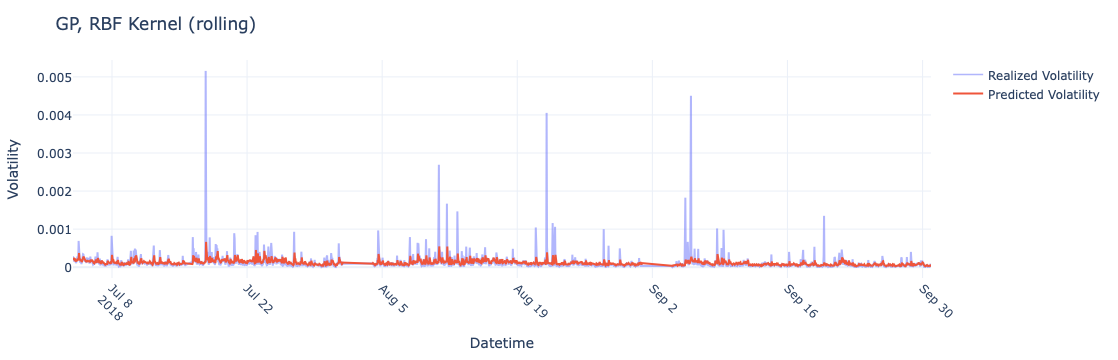

In [353]:
plot_preds(
    preds_dataframe=RBF_rolling_preds,
    model_name="GP, RBF Kernel",
    test_vols=test_vols,
    pred_type="rolling",
    naive=False,
)

### White Noise Kernel

In [355]:
WN_rolling_preds = back_tester(rolling_train_test_pairs, kernel=WhiteKernel())

WN_rolling_preds.to_csv("GP results/WN_rolling_preds.csv")

In [356]:
print(
    f"WN rolling RMSE = {root_mean_squared_error(WN_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"WN rolling MAE = {mean_absolute_error(WN_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

WN rolling RMSE = 0.2412825315441601
WN rolling MAE = 0.10283691191120387


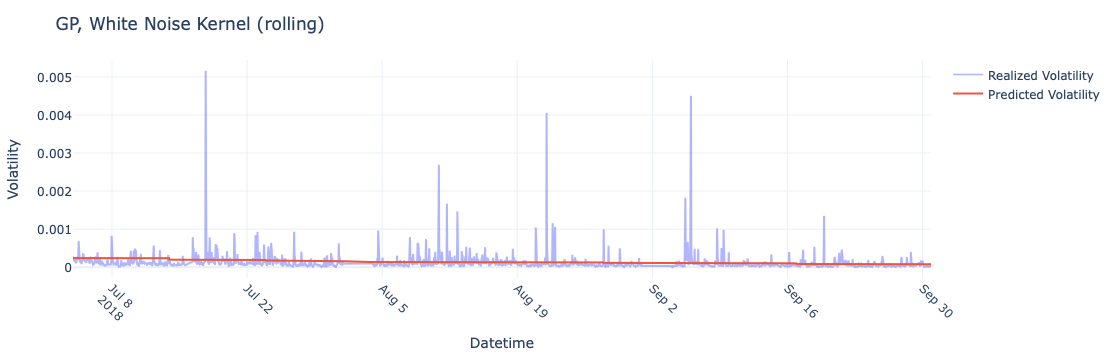

In [357]:
plot_preds(
    preds_dataframe=WN_rolling_preds,
    model_name="GP, White Noise Kernel",
    test_vols=test_vols,
    pred_type="rolling",
    naive=False,
)

### Periodic Kernel

In [359]:
PK_rolling_preds = back_tester(
    rolling_train_test_pairs,
    kernel=ConstantKernel() * ExpSineSquared() + WhiteKernel(),
    periodic_kernel=True,
)

PK_rolling_preds.to_csv("GP results/PK_rolling_preds.csv")

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 299.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 359.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 359.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: Conv

In [360]:
print(
    f"PK rolling RMSE = {root_mean_squared_error(PK_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"PK rolling MAE = {mean_absolute_error(PK_rolling_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

PK rolling RMSE = 0.2315988987676304
PK rolling MAE = 0.07904868183270564


In [361]:
plot_preds(
    preds_dataframe=PK_rolling_preds,
    model_name="GP, Periodic Kernel",
    test_vols=test_vols,
    pred_type="rolling",
    naive=False,
)

## Expanding Predictions

### RBF Kernel

In [364]:
RBF_expanding_preds = back_tester(
    expanding_train_test_pairs, kernel=ConstantKernel() * RBF() + WhiteKernel()
)

RBF_expanding_preds.to_csv("GP results/RBF_expanding_preds.csv")

In [365]:
print(
    f"RBF expanding RMSE = {root_mean_squared_error(RBF_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"RBF expanding MAE = {mean_absolute_error(RBF_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

RBF expanding RMSE = 0.2289239890007792
RBF expanding MAE = 0.07722229955590248


In [366]:
plot_preds(
    preds_dataframe=RBF_expanding_preds,
    model_name="GP, RBF Kernel",
    test_vols=test_vols,
    pred_type="expanding",
    naive=False,
)

### White Noise Kernel

In [368]:
WN_expanding_preds = back_tester(expanding_train_test_pairs, kernel=WhiteKernel())
WN_expanding_preds.to_csv("GP results/WN_expanding_preds.csv")

In [369]:
print(
    f"WN expanding RMSE = {root_mean_squared_error(WN_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"WN expanding MAE = {mean_absolute_error(WN_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

WN expanding RMSE = 0.24720306341304785
WN expanding MAE = 0.1309752542081806


In [370]:
plot_preds(
    preds_dataframe=WN_expanding_preds,
    model_name="GP, White Noise Kernel",
    test_vols=test_vols,
    pred_type="expanding",
    naive=False,
)

### Periodic Kernel

In [372]:
PK_expanding_preds = back_tester(
    expanding_train_test_pairs,
    kernel=ConstantKernel() * ExpSineSquared() + WhiteKernel(),
    periodic_kernel=True,
)
PK_expanding_preds.to_csv("GP results/PK_expanding_preds.csv")

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 395.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 455.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 515.5. Increasing the bound and calling fit again may find a better value.

/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: Conv

In [373]:
print(
    f"PK expanding RMSE = {root_mean_squared_error(PK_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)
print(
    f"PK expanding MAE = {mean_absolute_error(PK_expanding_preds['GP'].values, np.exp(test_vols['log_vol'])) * 1e3}"
)

PK expanding RMSE = 0.2289227997741465
PK expanding MAE = 0.07722433487150238


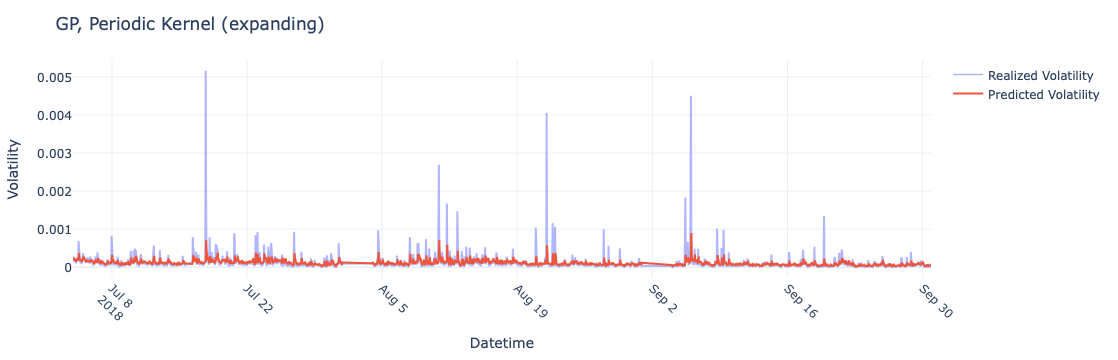

In [374]:
plot_preds(
    preds_dataframe=PK_expanding_preds,
    model_name="GP, Periodic Kernel",
    test_vols=test_vols,
    pred_type="expanding",
    naive=False,
)

## Observations

#### Rolling Predictions

<font size="3">Out of the three tested kernels, we can observe that both the RBF kernel and the Exp-Sine-Squared kernel outperform the simple white noise kernel, as the volatility is clearly not a simple white noise process. Although the RBF kernel and the Exp-Sine-Squared kernel performed similarly well during the training process, the GP model with the Exp-Sine-Squared kernel was encountering convergence warnings because the estimated periodicity of the kernel was approaching the provided upper bound. Since the volatility does not display any clear seasonality, it stands to reason that a periodic kernel, such as the Exp-Sine-Squared kernel, would be less suited than the more flexible RBF kernel.<font>

#### Expanding Predictions

<font size="3">Here we observe the same pattern, both the RBF kernel and the Exp-Sine-Squared kernel clearly outperform the simple white noise kernel. When compared to the rolling predictions, we can observe that both the RBF kernel and the Exp-Sine-Squared kernel improve both their root-mean-squared errors and their mean-absolute errors. However, the GP model with the simple white kernel has a noticeably reduced performance when using expanding training intervals.<font>